In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# ===========================================
# Setup
# ===========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [54]:
T = 100      # sequence length
tau = 5     # lag
d_model = 64
n_heads = 2
batch_size = 128

In [55]:
# ===========================================
# Synthetic Data Generator
# ===========================================
def generate_batch(batch_size, T, tau, obs_noise=0.05):
    """
    Generate paired behavior (beh) and neural (neu) data.
    neu has two channels:
      - Channel 0: behavior lagged forward by tau  (causal)
      - Channel 1: behavior lagged backward by tau (acausal)
    """
    beh = torch.randn(batch_size, T)

    # Forward-lagged: neural follows behavior (beh -> neu)
    neu_forward = torch.roll(beh, shifts=tau, dims=1)
    neu_forward[:, :tau] = 0.0  # zero-pad the start

    # Backward-lagged: neural precedes behavior (neu -> beh)
    neu_backward = torch.roll(beh, shifts=-tau, dims=1)
    neu_backward[:, -tau:] = 0.0  # zero-pad the end

    # Stack into two channels: [B, T, 2]
    neu = torch.stack([neu_forward, neu_backward], dim=-1)

    # Add observation noise
    neu += obs_noise * torch.randn_like(neu)

    # Behavior remains single-channel: [B, T, 1]
    beh = beh.unsqueeze(-1)

    return beh, neu

In [22]:
def generate_batch(batch_size, T, base_tau, max_jitter=2, obs_noise=0.0):
    beh = torch.randn(batch_size, T)
    neu = torch.zeros(batch_size, T, 2)
    for i in range(batch_size):
        tau = base_tau + torch.randint(-max_jitter, max_jitter+1, (1,)).item()
        sign = 1 if torch.rand(1).item() > 0.5 else -1  # randomize sign
        neu_f = torch.roll(beh[i], shifts=sign*tau)
        neu_f[:abs(tau)] = 0.0 if sign>0 else neu_f[:abs(tau)]
        neu_b = torch.roll(beh[i], shifts=-sign*tau)
        neu_b[-abs(tau):] = 0.0 if sign<0 else neu_b[-abs(tau):]
        neu[i,:,0], neu[i,:,1] = neu_f, neu_b
    neu += obs_noise * torch.randn_like(neu)
    beh = beh.unsqueeze(-1)
    return beh, neu


In [23]:
# ===========================================
# Synthetic Data Generator with Random Temporal Flipping
# ===========================================
def generate_batch(batch_size, T, tau, obs_noise=0.0, flip_prob=0.25):
    """
    Generate paired behavior (beh) and neural (neu) data.
    neu has two channels:
      - Channel 0: behavior lagged forward by tau  (causal)
      - Channel 1: behavior lagged backward by tau (acausal)

    With probability flip_prob, the entire sequence is time-reversed
    (so "past" and "future" swap places).
    This preserves causal structure but removes consistent directionality.
    """

    beh = torch.randn(batch_size, T)

    # Forward-lagged: neural follows behavior (beh -> neu)
    neu_forward = torch.roll(beh, shifts=tau, dims=1)
    neu_forward[:, :tau] = 0.0  # zero-pad the start

    # Backward-lagged: neural precedes behavior (neu -> beh)
    neu_backward = torch.roll(beh, shifts=-tau, dims=1)
    neu_backward[:, -tau:] = 0.0  # zero-pad the end

    # Stack into two channels: [B, T, 2]
    neu = torch.stack([neu_forward, neu_backward], dim=-1)

    # Add observation noise
    neu += obs_noise * torch.randn_like(neu)

    # Behavior remains single-channel: [B, T, 1]
    beh = beh.unsqueeze(-1)

    # --------------------------------------------
    # Random temporal flipping (time reversal)
    # --------------------------------------------
    flip_mask = torch.rand(batch_size) < flip_prob
    for i in range(batch_size):
        if flip_mask[i]:
            beh[i] = torch.flip(beh[i], dims=[0])
            neu[i] = torch.flip(neu[i], dims=[0])

    # reverse_causality_prob=0.3
    # reverse_mask = torch.rand(batch_size) < reverse_causality_prob
    # for i in range(batch_size):
    #     if reverse_mask[i]:
    #         # Swap roles: now neural drives behavior
    #         beh[i, :, 0] = torch.roll(neu[i, :, 0], shifts=tau, dims=0)
    #         beh[i, :tau, 0] = 0.0

    return beh, neu

In [30]:
import torch

def generate_batch(batch_size, T, base_tau, jitter=3, obs_noise=0.0):
    """
    Generate paired behavior (beh) and neural (neu) data with variable lags.
    Each sample has a slightly different lag (tau ± jitter), so the mapping
    between behavior and neural channels is inconsistent across the batch.
    
    Args
    ----
    batch_size : int
        Number of sequences per batch.
    T : int
        Sequence length.
    base_tau : int
        Mean lag (in timesteps).
    jitter : int
        Max deviation from base_tau (randomly chosen per sample).
    obs_noise : float
        Standard deviation of observation noise.

    Returns
    -------
    beh : [B, T, 1]       -- behavior signal
    neu : [B, T, 2]       -- neural channels (forward + backward)
    taus : list[int]      -- actual tau used for each sample
    """
    beh = torch.randn(batch_size, T)
    neu = torch.zeros(batch_size, T, 2)
    taus = []

    for i in range(batch_size):
        # random lag between base_tau - jitter and base_tau + jitter
        tau = int(base_tau + torch.randint(-jitter, jitter + 1, (1,)).item())
        taus.append(tau)

        # Forward-lagged: behavior precedes neural
        neu_forward = torch.roll(beh[i], shifts=tau, dims=0)
        neu_forward[:tau] = 0.0

        # Backward-lagged: neural precedes behavior
        neu_backward = torch.roll(beh[i], shifts=-tau, dims=0)
        neu_backward[-tau:] = 0.0

        neu[i, :, 0] = neu_forward
        neu[i, :, 1] = neu_backward

    # Add observation noise
    neu += obs_noise * torch.randn_like(neu)
    beh = beh.unsqueeze(-1)
    return beh, neu

In [56]:
import torch

def generate_batch(batch_size, T, tau, seg_len=25, obs_noise=0.0):
    """
    For each sequence:
      - Split the behavioral signal into segments of length seg_len
      - Within each segment:
          channel 0 = causal (behavior leads neural)
          channel 1 = acausal (neural leads behavior)
      - At the next segment, swap roles
    """
    beh = torch.randn(batch_size, T)
    neu = torch.zeros(batch_size, T, 2)

    for i in range(batch_size):
        num_segments = T // seg_len
        for s in range(num_segments):
            t0, t1 = s * seg_len, (s + 1) * seg_len
            seg = beh[i, t0:t1]

            # roll forward/backward versions of this segment
            causal_seg  = torch.roll(seg, shifts=+tau)
            acausal_seg = torch.roll(seg, shifts=-tau)

            if s % 2 == 0:
                # segment: ch0 = causal, ch1 = acausal
                neu[i, t0:t1, 0] = causal_seg
                neu[i, t0:t1, 1] = acausal_seg
            else:
                # swap roles
                neu[i, t0:t1, 0] = acausal_seg
                neu[i, t0:t1, 1] = causal_seg

    # Add small independent observation noise
    neu += obs_noise * torch.randn_like(neu)
    beh = beh.unsqueeze(-1)
    return beh, neu

In [57]:
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)

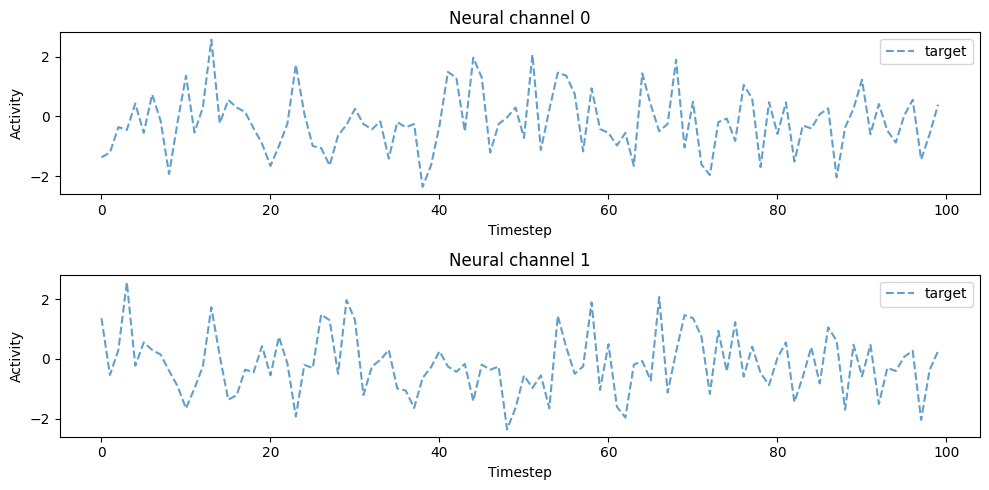

In [58]:
b = 0  # sample index
plt.figure(figsize=(10,5))
for c in range(neu_test.shape[-1]):
    plt.subplot(2,1,c+1)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()

In [59]:
# ===========================================
# Positional Encoding
# ===========================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, T, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

pos_enc = PositionalEncoding(d_model).to(device)

In [60]:
# ===========================================
# Minimal Cross-Attention Model
# (split into causal and acausal attention modules)
# ===========================================
class BiXLagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert n_heads % 2 == 0, "n_heads must be even for causal/acausal split"

        self.in_proj_beh = nn.Linear(1, d_model)
        self.in_proj_neu = nn.Linear(2, d_model)        
        
        self.n_heads = n_heads
        self.n_causal = n_heads // 2
        self.n_acausal = n_heads // 2

        # Two separate attention modules
        self.attn_causal = nn.MultiheadAttention(d_model, self.n_causal, batch_first=True)
        self.attn_acausal = nn.MultiheadAttention(d_model, self.n_acausal, batch_first=True)

        self.out_neu_proj = nn.Linear(2 * d_model, 2)
        self.out_beh_proj = nn.Linear(2 * d_model, 1)

    def forward(self, x, y_query):
        # x: encoder input [B, T_enc, 1]
        # y_query: decoder query [B, T_dec, 1]
        x_emb = pos_enc(self.in_proj_beh(x))
        y_emb = pos_enc(self.in_proj_neu(y_query))

        B, T_dec, _ = y_emb.shape
        T_enc = x_emb.shape[1]
        device = y_emb.device

        # ------------------------------------------------
        # Build attention masks
        # ------------------------------------------------
        mask_causal = torch.triu(torch.ones(T_dec, T_enc, device=device), diagonal=1).bool()
        mask_acausal = torch.tril(torch.ones(T_dec, T_enc, device=device), diagonal=-1).bool()

        # ------------------------------------------------
        # Apply both attention modules
        # ------------------------------------------------
        out_causal, w_causal = self.attn_causal(
            y_emb, x_emb, x_emb,
            attn_mask=mask_causal,
            need_weights=True,
            average_attn_weights=False
        )

        out_acausal, w_acausal = self.attn_acausal(
            y_emb, x_emb, x_emb,
            attn_mask=mask_acausal,
            need_weights=True,
            average_attn_weights=False
        )

        # Concatenate outputs and attention weights
        attn_out = torch.cat([out_causal, out_acausal], dim=-1)
        attn_weights = torch.cat([w_causal, w_acausal], dim=1)  # concat along head dimension

        out_neu = self.out_neu_proj(attn_out)
        out_beh = self.out_beh_proj(attn_out)

        return out_neu, out_beh, attn_weights, attn_out

In [61]:
# ===========================================
# Minimal Cross-Attention Model
# (split into causal and acausal attention modules)
# ===========================================
class LagAttentionModel(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert n_heads % 2 == 0, "n_heads must be even for causal/acausal split"

        self.in_proj_beh = nn.Linear(1, d_model)
        self.in_proj_neu = nn.Linear(2, d_model)        
        
        self.n_heads = n_heads
        self.n_causal = n_heads // 2
        self.n_acausal = n_heads // 2

        # Two separate attention modules
        self.attn_causal = nn.MultiheadAttention(d_model, self.n_causal, batch_first=True)
        self.attn_acausal = nn.MultiheadAttention(d_model, self.n_acausal, batch_first=True)

        self.out_neu_proj = nn.Linear(2 * d_model, 2)
        self.out_beh_proj = nn.Linear(2 * d_model, 1)

    def forward(self, x, y_query):
        # x: encoder input [B, T_enc, 1]
        # y_query: decoder query [B, T_dec, 1]
        x_emb = pos_enc(self.in_proj_beh(x))
        y_emb = pos_enc(self.in_proj_neu(y_query))

        # ------------------------------------------------
        # Apply both attention modules
        # ------------------------------------------------
        out_causal, w_causal = self.attn_causal(
            y_emb, x_emb, x_emb,
            need_weights=True,
            average_attn_weights=False
        )

        out_acausal, w_acausal = self.attn_acausal(
            y_emb, x_emb, x_emb,
            need_weights=True,
            average_attn_weights=False
        )

        # Concatenate outputs and attention weights
        attn_out = torch.cat([out_causal, out_acausal], dim=-1)
        attn_weights = torch.cat([w_causal, w_acausal], dim=1)  # concat along head dimension

        out_neu = self.out_neu_proj(attn_out)
        out_beh = self.out_beh_proj(attn_out)

        return out_neu, out_beh, attn_weights, attn_out

In [62]:
n_steps = 2000

In [63]:
# instantiate / train as usual
model = BiXLagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    beh, neu = generate_batch(batch_size, T, tau)
    beh, neu = beh.to(device), neu.to(device)
    neu_query = torch.zeros_like(neu)  # decoder starts with zeros

    neu_pred, beh_pred, _, _ = model(beh, neu_query)
    #loss = loss_fn(torch.cat((neu_pred, beh_pred), dim=-1),
    #           torch.cat((neu, beh), dim=-1))    
    loss = loss_fn(neu_pred, neu)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

Step 500/2000, Loss: 0.595396
Step 1000/2000, Loss: 0.350618
Step 1500/2000, Loss: 0.325411
Step 2000/2000, Loss: 0.321530


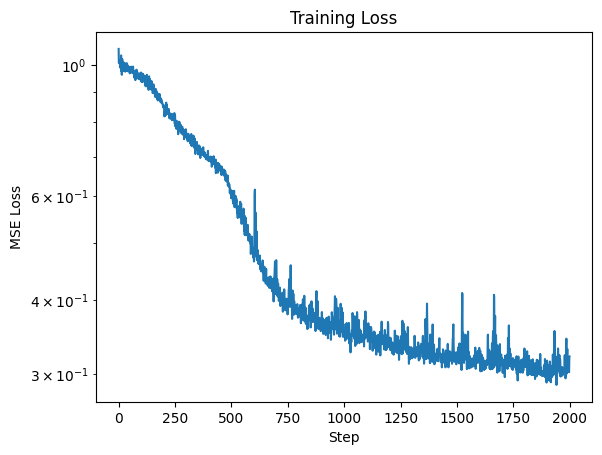

In [64]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [65]:
# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, attn_out = model(beh_test, neu_query)

attn_weights.shape

torch.Size([1, 2, 100, 100])

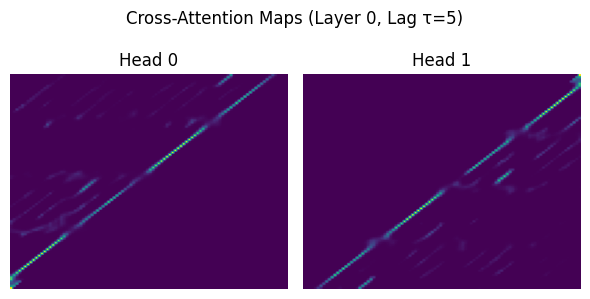

In [66]:
import math

layer_attn = attn_weights[0]  # shape (n_heads, T_dec, T_enc)
n_heads = layer_attn.shape[0]
cols = math.ceil(math.sqrt(n_heads))
rows = math.ceil(n_heads / cols)

plt.figure(figsize=(3 * cols, 3 * rows))
for h in range(n_heads):
    attn_map = layer_attn[h].cpu().numpy()
    plt.subplot(rows, cols, h + 1)
    plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Head {h}')
    plt.axis('off')

plt.suptitle(f'Cross-Attention Maps (Layer 0, Lag τ={tau})')
plt.tight_layout()
plt.show()

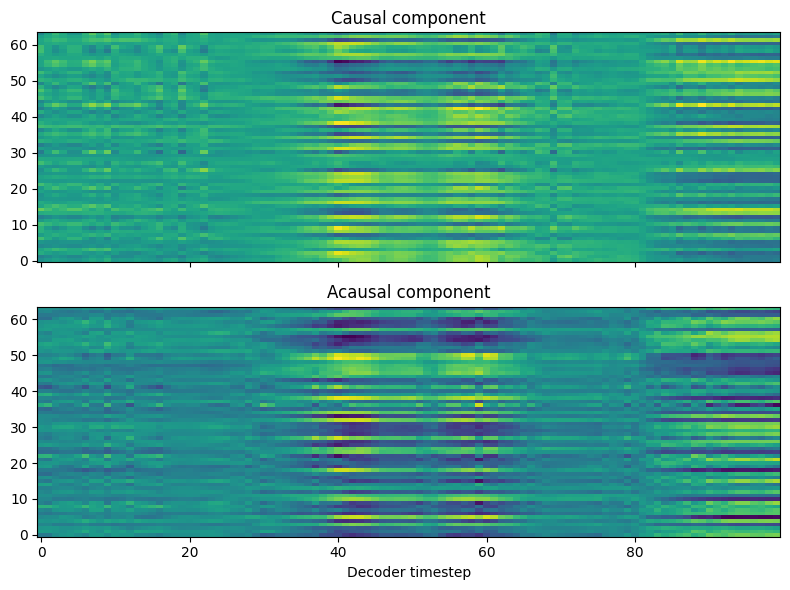

In [68]:
B, T, D2 = attn_out.shape
D = D2 // 2
causal_out = attn_out[0, :, :D]
acausal_out = attn_out[0, :, D:]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True)
ax[0].imshow(causal_out.detach().cpu().T, aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title("Causal component")
ax[1].imshow(acausal_out.detach().cpu().T, aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title("Acausal component")
ax[1].set_xlabel("Decoder timestep")
plt.tight_layout()
plt.show()

In [69]:
neu_pred.shape

torch.Size([1, 100, 2])

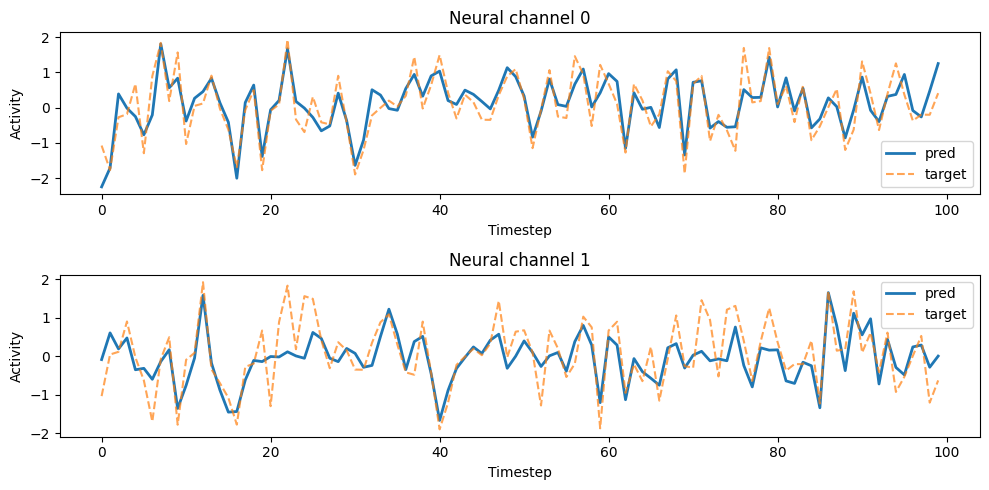

In [70]:
b = 0  # sample index
plt.figure(figsize=(10,5))
for c in range(neu_pred.shape[-1]):
    plt.subplot(2,1,c+1)
    plt.plot(neu_pred[b,:,c].detach().cpu(), label='pred', lw=2)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()

## No seperation

In [71]:
# instantiate / train as usual
model = LagAttentionModel(d_model, n_heads).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===========================================
# Training
# ===========================================
loss_history = []
for step in range(n_steps):
    beh, neu = generate_batch(batch_size, T, tau)
    beh, neu = beh.to(device), neu.to(device)
    neu_query = torch.zeros_like(neu)  # decoder starts with zeros

    neu_pred, beh_pred, _, _ = model(beh, neu_query)
    #loss = loss_fn(torch.cat((neu_pred, beh_pred), dim=-1),
    #           torch.cat((neu, beh), dim=-1))    
    loss = loss_fn(neu_pred, neu)    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if (step+1) % 500 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}")

Step 500/2000, Loss: 0.648061
Step 1000/2000, Loss: 0.171291
Step 1500/2000, Loss: 0.037277
Step 2000/2000, Loss: 0.014313


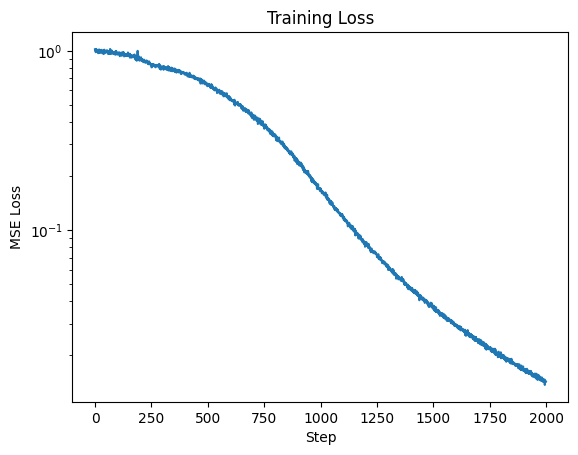

In [72]:
# Plot loss
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Step')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.show()

In [73]:
# ===========================================
# Visualization
# ===========================================
beh_test, neu_test = generate_batch(1, T, tau)
beh_test, neu_test = beh_test.to(device), neu_test.to(device)
neu_query = torch.zeros_like(neu_test)

with torch.no_grad():
    neu_pred, beh_pred, attn_weights, attn_out = model(beh_test, neu_query)

attn_weights.shape

torch.Size([1, 2, 100, 100])

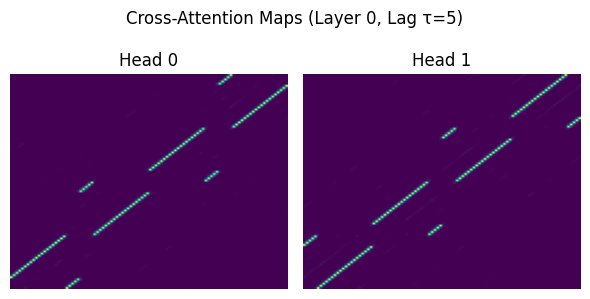

In [74]:
import math

layer_attn = attn_weights[0]  # shape (n_heads, T_dec, T_enc)
n_heads = layer_attn.shape[0]
cols = math.ceil(math.sqrt(n_heads))
rows = math.ceil(n_heads / cols)

plt.figure(figsize=(3 * cols, 3 * rows))
for h in range(n_heads):
    attn_map = layer_attn[h].cpu().numpy()
    plt.subplot(rows, cols, h + 1)
    plt.imshow(attn_map, aspect='auto', origin='lower', cmap='viridis')
    plt.title(f'Head {h}')
    plt.axis('off')

plt.suptitle(f'Cross-Attention Maps (Layer 0, Lag τ={tau})')
plt.tight_layout()
plt.show()

In [75]:
attn_out.shape

torch.Size([1, 100, 128])

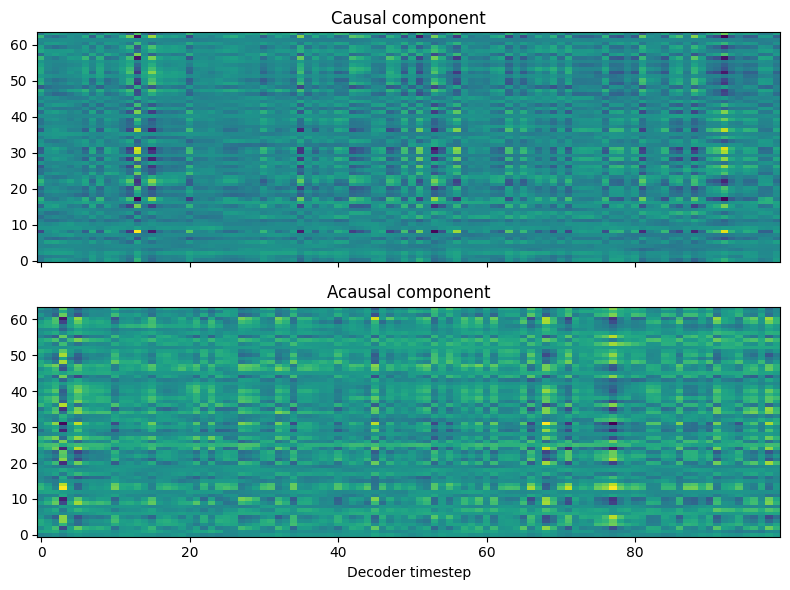

In [76]:
B, T, D2 = attn_out.shape
D = D2 // 2
causal_out = attn_out[0, :, :D]
acausal_out = attn_out[0, :, D:]

fig, ax = plt.subplots(2,1, figsize=(8,6), sharex=True)
ax[0].imshow(causal_out.detach().cpu().T, aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title("Causal component")
ax[1].imshow(acausal_out.detach().cpu().T, aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title("Acausal component")
ax[1].set_xlabel("Decoder timestep")
plt.tight_layout()
plt.show()

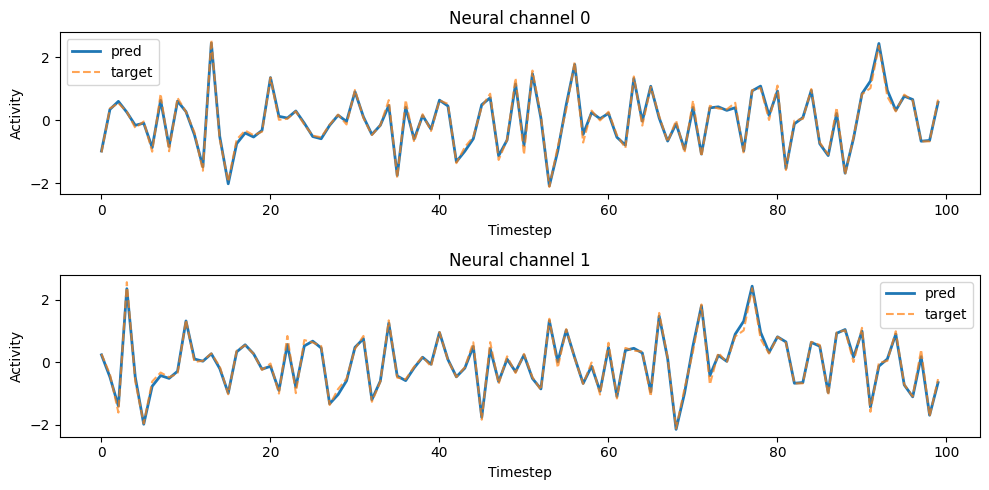

In [77]:
b = 0  # sample index
plt.figure(figsize=(10,5))
for c in range(neu_pred.shape[-1]):
    plt.subplot(2,1,c+1)
    plt.plot(neu_pred[b,:,c].detach().cpu(), label='pred', lw=2)
    plt.plot(neu_test[b,:,c].detach().cpu(), '--', label='target', alpha=0.7)
    plt.title(f'Neural channel {c}')
    plt.xlabel('Timestep')
    plt.ylabel('Activity')
    plt.legend()
plt.tight_layout()
plt.show()